# <center>Células estocásticas</center>

In [1]:
using PyPlot

INFO: Loading help data...


###El chiste de este proyecto es ver cuando tiene sentido ver las reacciones que suceden en las celulas, que normalmente tienen pocos componentes, como procesos estocásticos en lugar de deterministas.

###Para esto vamos a ver un modelo sencillo en el que se tiene una concentración de componentes de una sola molécula [M] por 'monomer'. Estos se convierten en componentes de dos moléculas (cuya concentración será [D] por 'dimer') con taza de conversión $k_b$. La taza para que regresen a ser unimolculares será $k_u$.

###La reacción a modelar está resumida en el siguiente diagrama de Petri, donde las flechas entrantes a un círculo indican resultado de una reacción y salientes el componente entrante de la reacción.

<img src="petri.png">

###Primero analizamos el caso "determinista":
###Para que M tambien sea el numero de monómeros en la célula asumiremos de ahora en adelante que nuestra unidad de concentración esta dada en nanomoles. Usando esto, la ecuación diferencial que rige el cambio en M es: $$\frac{\delta M}{\delta t}= k_u D - 1/2k_b M²$$

###Para que haya equilibrio queremos que la derivada sea igual a 0, si ademas usamos que la concentración total de moleculas es $N=M+2D$, obtenemos que $ M=\frac{\sqrt{\text{ku}} \sqrt{4 \text{kb} n+\text{ku}}-\text{ku}}{2 \text{kb}} $

###Ahora veamos como se comporta la solución numérica a esta ecuación diferencial. Primero resolvamos para 90 moléculas. En este casa la solución de equilibrio es $M=12.4536$

In [2]:
using ODE #Importamos el paquete para resolver ODE's de Julia

In [67]:
function celula_determ(N::Int64, tfin::Float64, plots::Bool=false, M0::Float64=-1., ku::Float64=2.,kb::Float64=1. )
    M0= M0==-1 ? float(rand(0:N)) : M0        #Si no se asigno un valor para los monomeros se escoge uno aleatorio
    
    dMdt(t,M)=1./2.*(ku*(N-M)-kb*M^2.) #La ecuación diferencial    
    tspan= [0:tfin/1000.:tfin]  #El intervalo sobre el que resolveremos

    #Aqui resolvemos la ecuación con ode23 que resulver hasta 2° y 3° orden
    tout, Mout = ode23(dMdt, M0, tspan)
    if(plots)
        plot(tout, Mout)
    end
    return tout,Mout
end

celula_determ (generic function with 11 methods)

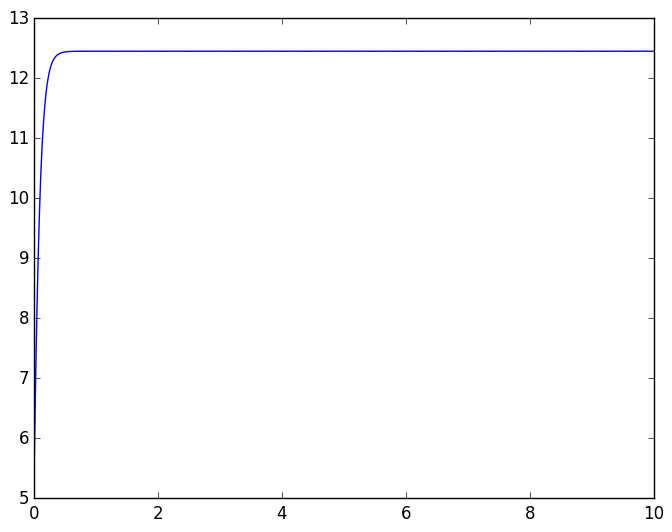

([0.0,0.00118865,0.00713192,0.0155787,0.0255046,0.0389889,0.0512774,0.0634869,0.07429,0.084492  …  8.48017,8.66677,8.85265,9.03917,9.22656,9.41382,9.6003,9.78654,9.97332,10.0],[5.0,5.08587,5.50585,6.07527,6.70219,7.48007,8.1158,8.68079,9.1281,9.50793  …  12.4535,12.4538,12.4535,12.4537,12.4535,12.4538,12.4535,12.4538,12.4535,12.4535])

In [39]:
celula_determ(90,10.,true,5.)

###Se puede ver que se estabiliza en el mismo valor con una exactitud de 3 cifras significativas q claro q dependen de la definción de nuestro intervalo.
###Ahora hagámos lo mismo para N=2, en este caso se deberia de estabilizar en $M=1.23607$

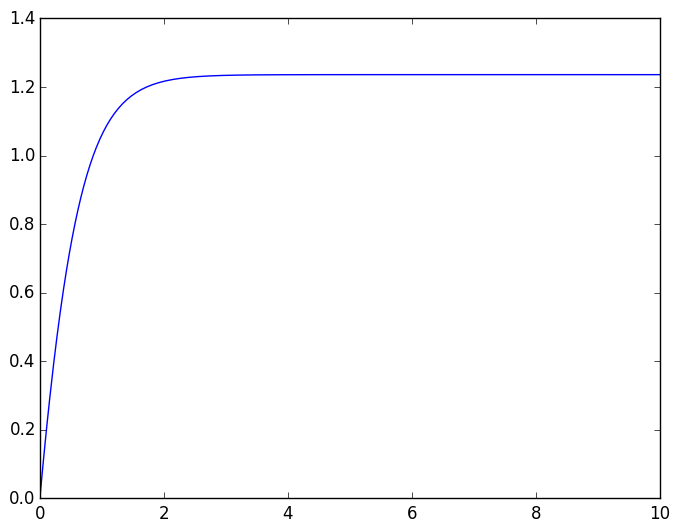

([0.0,8.61774e-6,5.17064e-5,0.00026715,0.00134437,0.00673045,0.0186455,0.035682,0.0575644,0.0846088  …  3.17301,3.46218,3.84237,4.47256,5.0801,6.0801,7.0801,8.0801,9.0801,10.0],[0.0,1.72354e-5,0.00010341,0.000534228,0.00268693,0.0134155,0.0369413,0.0700767,0.111758,0.161887  …  1.23467,1.23534,1.23577,1.23603,1.23606,1.23607,1.23607,1.23607,1.23607,1.23607])

In [41]:
celula_determ(2,10.,true,0.)

###Se puede ver que se tiende como siempre al equilibrio, pero en un escenario real debería de haber grandes fluctuaciones cuando no hay tantas moleculas. A estas se les llama *shot noise* q se traduce a ruido de disparo.
###Así que lo que vamos a hacer es trabajar de manera estocástica.

###En este caso usaremos el algoritmo Montecarlo de tiempo continuo. En este algoritmo se quita la inconveniencia de hacer el step muy pequeño, utilizando una distribución de probabilidades continua para el siguiente tiempo de ocurrencia de un evento.
###Muy burdamente se parte de que la probabilidad de que no suceda un evento en un tiempo $\Delta t$ desde el tiempo $t$ es $ P_0(t+\Delta t)=P_0(t)(1-a \Delta t) $ de ahí se hace tender $\Delta t \rightarrow 0$ y, usando la independencia de eventos se llega  una ecuación diferencial. 
###Tomando en cuenta que puede haber mas de un evento evento se llega a la sigueinte distribucion de probabilidad para cuando ocurre el siguiente evento$t$. $$P(t)=\lambda \exp{-\lambda t}$$
###Donde $\lambda=\sum{l_i}$ Y $l_i$ es la razón de cada evento.

###En este caso tenemos dos reacciones $l_1=1/2 k_b M (M-1)$ y $l_2=k_u D$

###Ademas si se integra la probabilidad para que suceda uno de lo eventos primero $P_{l_i}=l_i exp{-\lambda t}$ se obtiene que la probabilidad de que ese evento sea li, osea $p_{l_i}=l_i/\lambda$

###Asi que el algoritmo lo que hace es:
<ul>
<li>Obtener la $\lambda$ del sistema en su estado actual. 
<li>Obtener el tiempo de la siguiente reacción con ayuda de la distribución $\Delta t$
<li>Ver cual de los eventos ocurrió con la probabilidad que obutvimos
<li>Avanzar el tiempo del sistema por $\Delta t$
<li>Actualizar el numero de monomeros y duomeros
</ul>

In [23]:
function random_t_espera(λ::Float64) #La función que nos regresa el tiempo con la distribución deseada
    -log( rand()/λ ) / λ
end

random_t_espera (generic function with 1 method)

In [66]:
function celula_estocastica(N::Int64,t_final::Float64, plots::Bool=false, M0::Float64=-1.,k_u::Float64=2.,k_b::Float64=1.)
    #N es el número total de monómeros del sistema iniciales, unidos o no
    M0= M0==-1 ? float(rand(0:N)) : M0        #Si no se asigno un valor para los monomeros se escoge uno aleatorio
    M=[M0]                                   
    T=[0.0]
    t_aux=0                            #tiempo que indica cuando para el proceso
    
    while t_aux <= t_final                        #primero encontramos las razones, y así la razón total
        i = length(M)
        r_m = k_u * (N-M[i])/2
        r_d = k_b * ((M[i]) * (M[i]-1))/2
        r_tot = r_m + r_d                          #este es el rate total
        t_aux += random_t_espera(r_tot)
        if t_aux <= t_final
            r = r_tot * rand()
            push!(T,t_aux)
            if r <r_m
                push!(M,(M[i]+2))
            else
                push!(M,(M[i]-2))
            end
        end
    end
    if(plots)
        plot(T,M,".-")
    end
    return T,M
end

celula_estocastica (generic function with 11 methods)

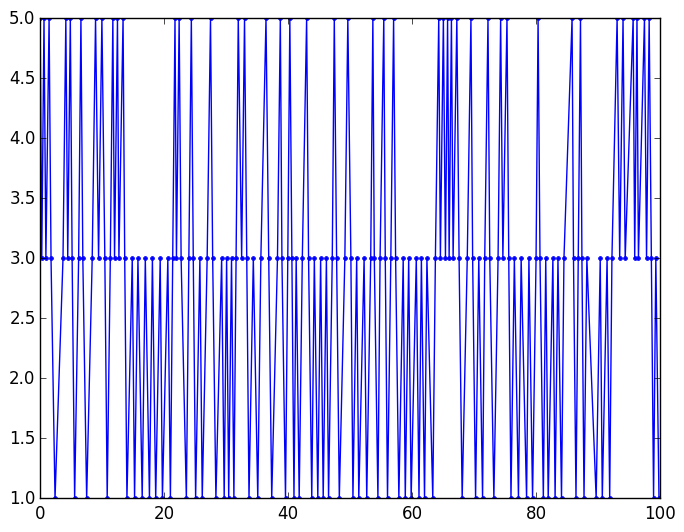

([0.0,0.26129,0.624267,0.929102,1.44341,1.75632,2.4014,3.68809,4.14644,4.45274  …  95.8993,96.266,96.4982,97.4739,97.8067,98.2308,98.5853,98.9413,99.3052,99.8134],[5.0,3.0,5.0,3.0,5.0,3.0,1.0,3.0,5.0,3.0  …  3.0,5.0,3.0,5.0,3.0,5.0,3.0,1.0,3.0,1.0])

In [62]:
celula_estocastica(5,100.,true)

###Se puede ver que ahora en el caso de N=4 no se tiende a un valor de equilibrio sino que el ruido es constante

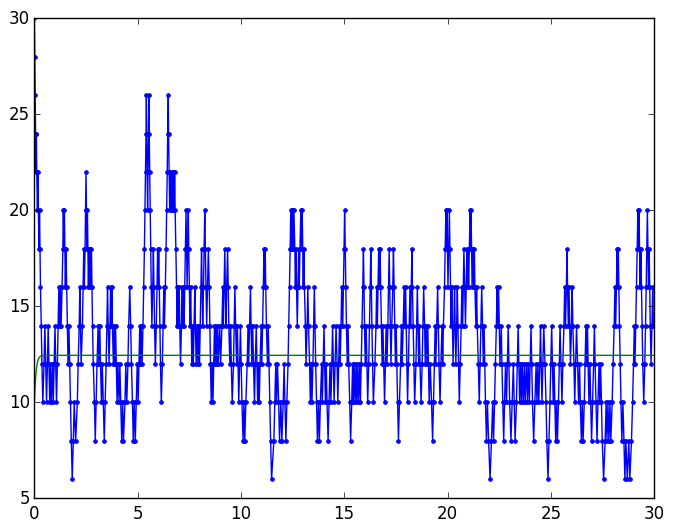

([0.0,0.00574516,0.0156053,0.0257095,0.0360042,0.0465407,0.057371,0.0685477,0.0801258,0.0921649  …  28.4204,28.6071,28.7939,28.9807,29.1674,29.3542,29.541,29.7278,29.9145,30.0],[10.0,10.167,10.4297,10.6699,10.8872,11.0837,11.2612,11.4213,11.5653,11.6944  …  12.4535,12.4538,12.4535,12.4538,12.4535,12.4538,12.4535,12.4538,12.4535,12.4536])

In [63]:
tfin=30. 
N=90

celula_estocastica(N,tfin,true,30.)
celula_determ(N,tfin,true,10.)

###Para valores mayores se tiende a un intervalo de valores con cierto ruido. Este intervalo se mueve alrededor de la condicion de equilibrio q obtuvimos.
###Ahora busquemos el valor para el cual el porcentaje del ruido es 20%

In [357]:
#Hacemos una función q nos diga el porcenta de ruido alredor del equilibrio
function ruido_disparo(N::Int64,plots::Bool=false)
    #Hacemos las simulaciones
    tD,molsD=celula_determ(N,50.,plots) 
    tS,molsS=celula_estocastica(N,50.,plots)
    
    equilibrio=molsD[end] #Obtenemos el valor del equilibrio    
    molsS=molsS[80:end] #Quitamos la "cola"
    
    molsS=molsS-equilibrio
    promedioDesv=sum(abs(molsS))/length(molsS) #Obtenemos un promedio de la desviacion    
    return promedioDesv/equilibrio
end

ruido_disparo (generic function with 2 methods)

In [376]:
ruido_disparo(150)

0.20818297233372565

###A partir de las 150 moleculas, el ruido empieza a ser del 20%
###Las mediciones en un laboratorio se promedian entre muchas celulas y por eso, aunque haya muy pocas moleculas, el ruido puede ser muy pequeño.
###Asi que analizemos el ruido en el promedio

In [488]:
function ruido_disparo_promedio(N::Int64,veces::Int64=int(5e2))
    suma=0
    for i in 1:veces
            suma+=ruido_disparo(N)
    end
    return suma/veces
end

ruido_disparo_promedio (generic function with 4 methods)

In [507]:
ruido_disparo_promedio(150)

0.2015016792370804

In [506]:
ruido_disparo(150)

0.193847595598019